In [1]:
%reset -f
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as pl
import sys, os
sys.path.append('../')
from binacox import get_m_1, get_m_2
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

## Compute metrics

In [2]:
n_features = 50
rslt_dir = "./results_data/p_%s/" % n_features
methods = ["binacox", "auto_cutoff_bonferroni", "auto_cutoff_laus_schu"]
#methods = ["auto_cutoff_bonferroni", "auto_cutoff_laus_schu"]
metrics = ["m_1", "m_2", "m_3"]
alpha = .05
start = False
for n_cut_points in [1, 2, 3]:
    for method in methods: 
        method_ = method if method == "binacox" else "auto_cutoff"
        rslt = pd.read_json(rslt_dir + "results_%s_n_cut_points_%s" % (method_, n_cut_points))
        n_samples_grid = list(np.sort(rslt.n_samples.unique()))
        if not start:
            columns = ["method", "n_cut_points", "metric"] + n_samples_grid
            results = pd.DataFrame(columns=columns)
            start = True
        metric_data = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
        for n in n_samples_grid:    
            rslt_n = rslt[rslt.n_samples == n]
            metric_n = {"1":[], "2":[], "3":[]}
            for simu_idx in rslt_n.index:
                cut_points = rslt_n.cut_points[simu_idx]
                cut_points_estimates = rslt_n.cut_points_estimates[simu_idx]
                S = rslt_n.S[simu_idx]
                if method != "binacox":
                    p_values_corr = rslt_n.p_values_corr[simu_idx]
                    p_values_min = rslt_n.p_values_min[simu_idx]
                    n_tested = rslt_n.n_tested[simu_idx]     
                    if method == "auto_cutoff_bonferroni":
                        idx_nan = []
                        for i in range(len(p_values_min)):
                            if p_values_min[i] > alpha / n_tested[i]:
                                idx_nan += [i]
                    if method == "auto_cutoff_laus_schu":
                        idx_nan = np.where(np.array(p_values_corr) > alpha)[0]
                    np.array(cut_points_estimates)[idx_nan] = np.nan
                    cut_points_estimates_ac = {}
                    for j in range(len(cut_points_estimates)):
                        est_j = [None, None]
                        if cut_points_estimates[j] == cut_points_estimates[j]:
                            est_j.insert(1, cut_points_estimates[j])
                        cut_points_estimates_ac[str(j)] = est_j
                    cut_points_estimates = cut_points_estimates_ac 
                hat_K_star, K_star = np.array([]), np.array([])
                for j in range(len(cut_points_estimates)):
                    hat_K_star = np.append(hat_K_star, len(cut_points_estimates[str(j)]) - 2)
                    K_star_j = 0 if j in S else len(cut_points[str(j)]) - 2
                    K_star = np.append(K_star, K_star_j)
                metric_n["1"] += [get_m_1(hat_K_star, K_star, len(cut_points_estimates))]
                metric_n["2"] += [get_m_2(cut_points_estimates, cut_points, S)]
                metric_n["3"] += [get_m_1(hat_K_star[S], K_star[S], len(S))]
                
                #if method == "auto_cutoff_bonferroni" and n_cut_points == 1:
                #    print(get_m_1(hat_K_star[S], K_star[S], len(S)))
                
            for i in range(3):
                metric_data[i][n] = metric_n[str(i + 1)]
        for i, metric in enumerate(metrics):
            metric_data[i]["method"] = method
            metric_data[i]["n_cut_points"] = n_cut_points
            metric_data[i]["metric"] = metric
            results = results.append(metric_data[i], ignore_index=True)

In [ ]:
rslt

In [ ]:
rslt = pd.read_json(rslt_dir + "results_%s_n_cut_points_%s" % ("auto_cutoff", 1))
test = rslt.ix[0,:]
S = test.S
print(S)
#cut_points_estimates
#print(cut_points[str(S[0])])
test
#test.p_values_corr
test.p_values_min

## Plot results

300    -1.4
343    -1.4
394    -1.4
451    -1.4
517    -1.4
593    -1.4
679    -1.4
779    -1.4
892    -1.4
1023   -1.4
1172   -1.4
1344   -1.4
1540   -1.4
1765   -1.4
2023   -1.4
2318   -1.4
2657   -1.4
3045   -1.4
3490   -1.4
4000   -1.4
dtype: float64


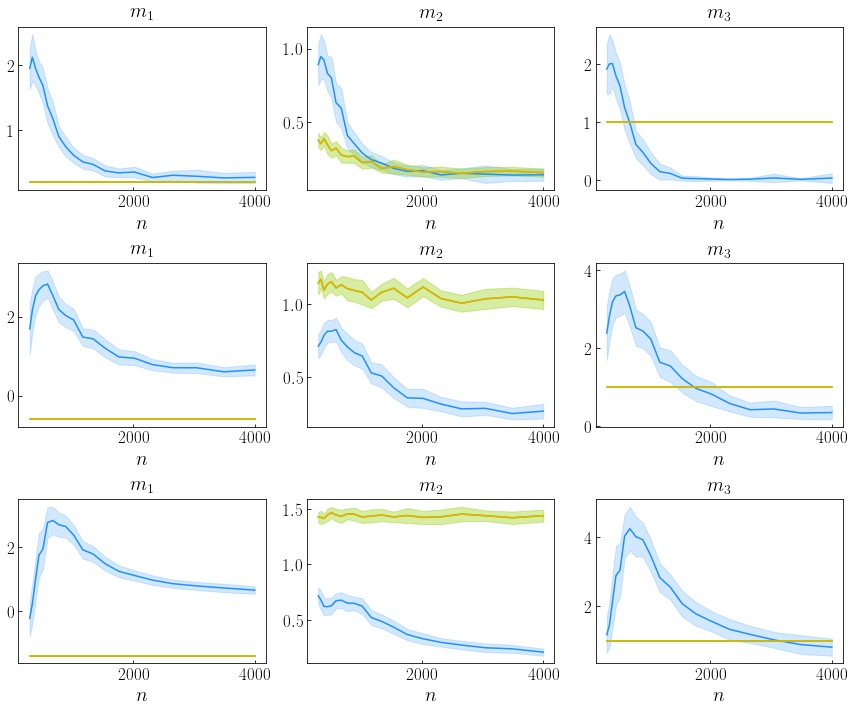

In [3]:
fig = pl.figure(figsize=(12, 10))
method_color = ["dodgerblue", "lime", "orange"]
for idx_method, method in enumerate(methods):
    k = 1
    for n_cut_points in [1, 2, 3]:
        for metric in metrics:            
            ax = fig.add_subplot(3, 3, k)
            k += 1
            data = results[(results.method == method) &
                           (results.n_cut_points == n_cut_points) &
                           (results.metric == metric)]
            data.drop(["method", "n_cut_points", "metric"], axis=1, inplace=True)
            mean = data.mean()
            
            if method == "auto_cutoff_bonferroni" and n_cut_points == 3 and metric == "m_1":
                print(mean)
            
            eps = data.std() / np.sqrt(len(n_samples_grid)) * 1.96
            pl.plot(n_samples_grid, mean, color=method_color[idx_method], label='')
            pl.fill_between(n_samples_grid, mean - eps, mean + eps, 
                            color=method_color[idx_method], alpha=0.2)            
            ax.tick_params(axis='both', which='major', direction='in', labelsize=17)
            ax.set_xlabel('$n$', fontsize=20)
            pl.title("$%s$" % metric, fontsize=20)
pl.tight_layout()
if True:
    directory = "./figures/p_%s" % n_features
    try:
        os.stat(directory)
    except:
        os.mkdir(directory)
    pl.savefig(directory + '/result_montecarlo.pdf', bbox_inches='tight')
pl.show()

In [ ]:
on vire m1 et à la place de m3 on fait du 0/1 courbe d'AUC, que sur K^\star = 1?
et commencer à n=500 pr pas avoir le souci du début

In [ ]:
import sys, os, smtplib

sys.path.append('../')
import pandas as pd
import numpy as np
from sys import stdout, argv
from time import time
from sklearn.externals.joblib import Parallel, delayed
from tick.simulation import SimuCoxRegWithCutPoints
from tick.preprocessing.features_binarizer import FeaturesBinarizer
from tick.inference import CoxRegression
from binacox import compute_score, auto_cutoff, get_groups, p_value_cut

n_features = 10
n_cut_points = 1
n_samples = 300

seed = 0
cov_corr = .5
sparsity = .2
simu = SimuCoxRegWithCutPoints(n_samples=n_samples,
                               n_features=n_features,
                               n_cut_points=n_cut_points,
                               seed=seed, verbose=False,
                               shape=2, scale=.1, cov_corr=cov_corr,
                               sparsity=sparsity)
X, Y, delta, cut_points, beta_star, S = simu.simulate()

# binarize data
n_cuts = 50
binarizer = FeaturesBinarizer(n_cuts=n_cuts)
binarizer.fit_transform(X)
boundaries = binarizer.boundaries
epsilon = 10

tic = time()
auto_cutoff_rslt = auto_cutoff(X, boundaries, Y, delta, epsilon=epsilon)
# Lausen & Schumacher correction
p_values_corr, p_values_min, cut_points_estimates = [], [], []
n_tested = []
for j in range(n_features):
    p_values_j = auto_cutoff_rslt[j]
    n_tested.append(p_values_j.values_to_test.shape[0])
    p_values_min.append(p_values_j.p_values.min())
    p_values_corr.append(
        p_value_cut(p_values_j.p_values, p_values_j.values_to_test,
                    X[:, j], epsilon))
    idx_cut_points = p_values_j.p_values.argmin()
    cut_points_estimate_j = p_values_j.values_to_test[
        idx_cut_points]
    cut_points_estimates.append(cut_points_estimate_j)
tac = time()

In [ ]:
print(S)
p_values_corr